## Correlation Analysis

/home/gautom/miniconda3/envs/LAVIS/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


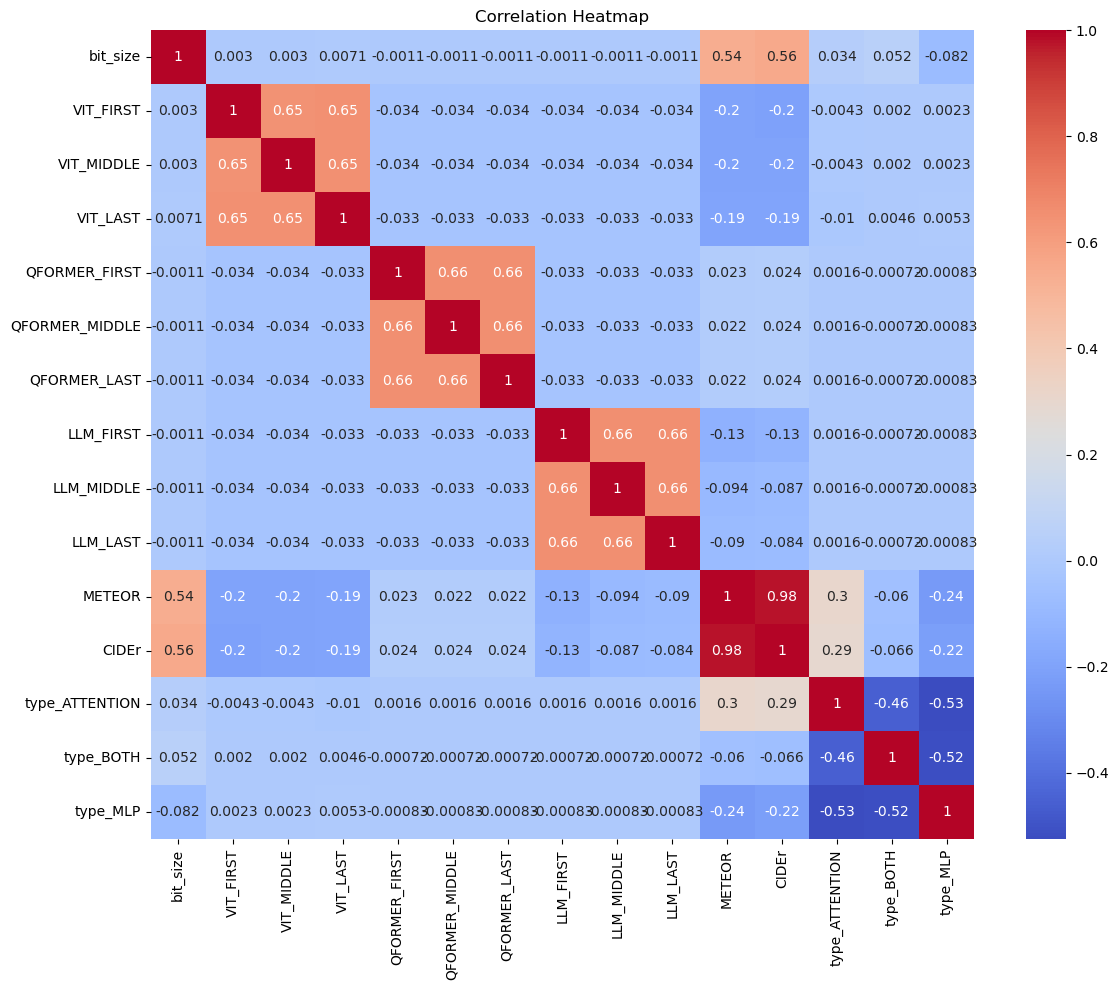

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Load the data
df = pd.read_csv('quantization_results.csv')

# Drop the 'config' column
df = df.drop('config', axis=1)

# One-hot encode the 'type' column
onehot = OneHotEncoder(sparse=False)
type_encoded = onehot.fit_transform(df[['type']])
type_columns = onehot.get_feature_names(['type'])
df_encoded = pd.concat([df.drop('type', axis=1), pd.DataFrame(type_encoded, columns=type_columns)], axis=1)

# Correlation analysis
correlation_matrix = df_encoded.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

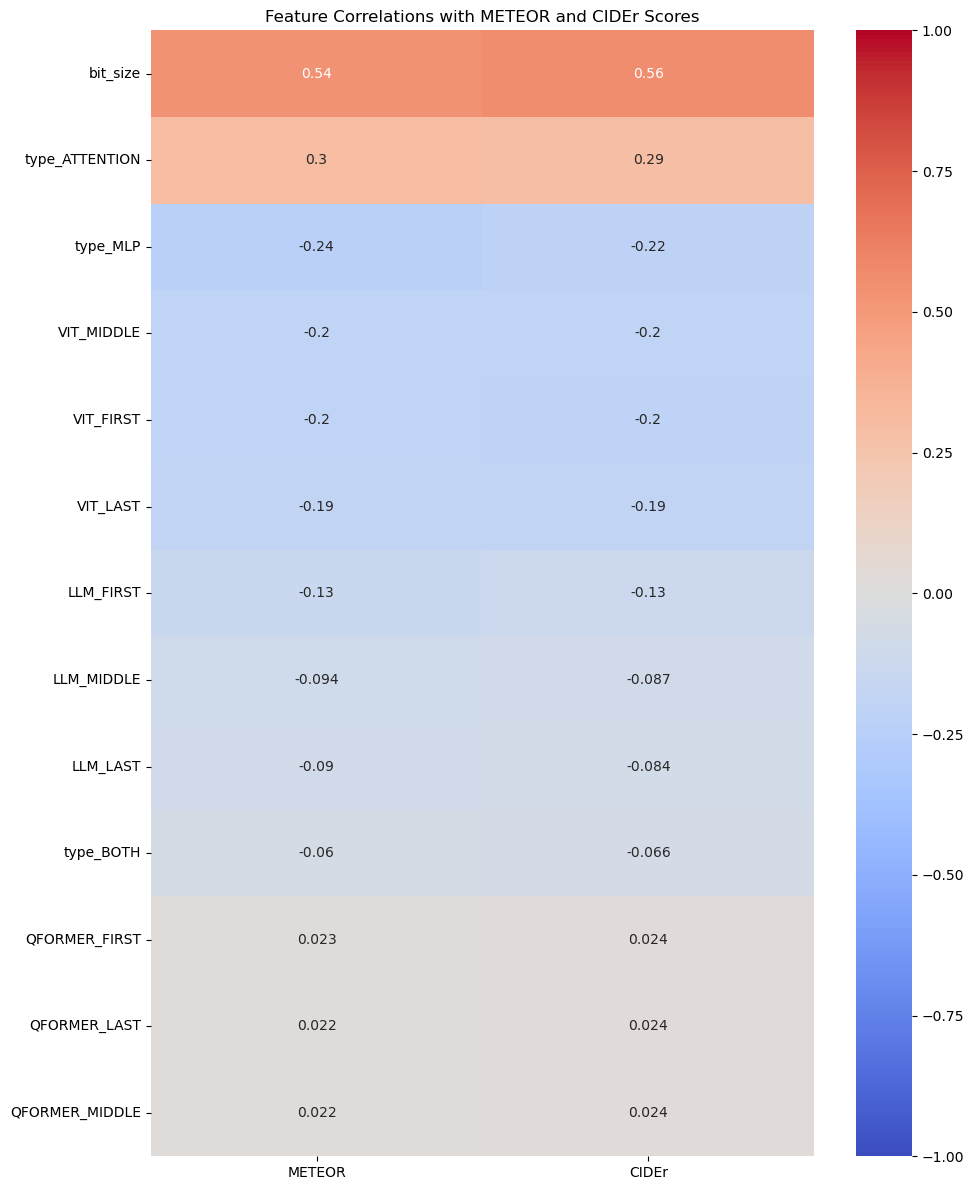

In [23]:
features = df_encoded.drop(['METEOR', 'CIDEr'], axis=1).columns

# Calculate correlations
correlations = df_encoded[features].corrwith(df_encoded['METEOR']).to_frame(name='METEOR')
correlations['CIDEr'] = df_encoded[features].corrwith(df_encoded['CIDEr'])

# Sort by absolute correlation with METEOR
correlations = correlations.reindex(correlations['METEOR'].abs().sort_values(ascending=False).index)

# Create heatmap
plt.figure(figsize=(10, 12))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Feature Correlations with METEOR and CIDEr Scores')
plt.tight_layout()
plt.show()

## Random Forest Regressor

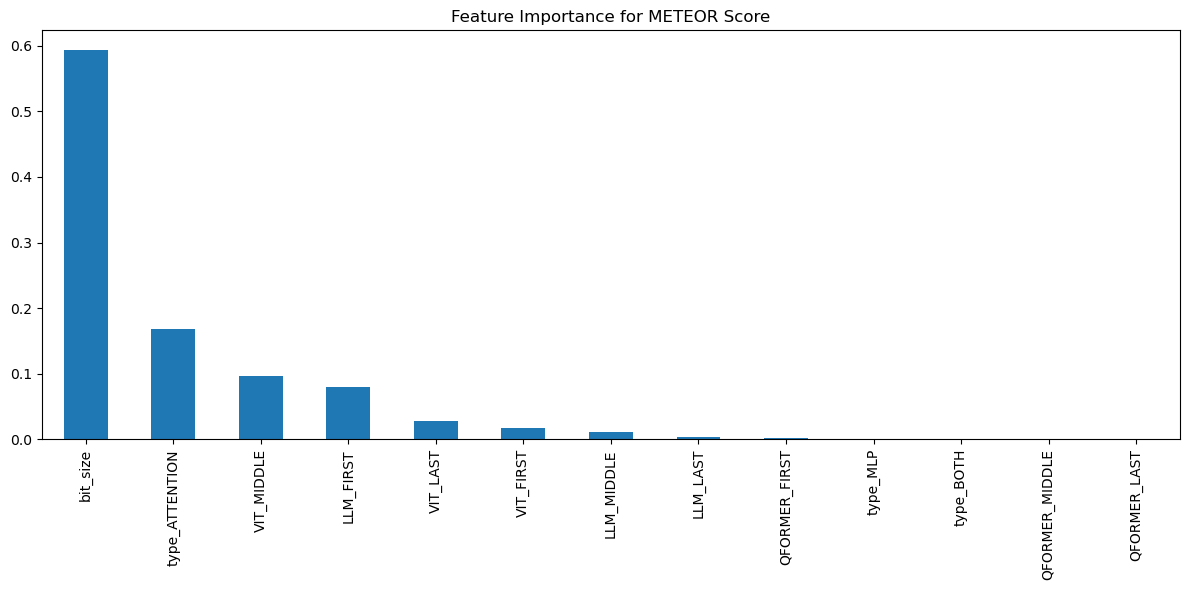

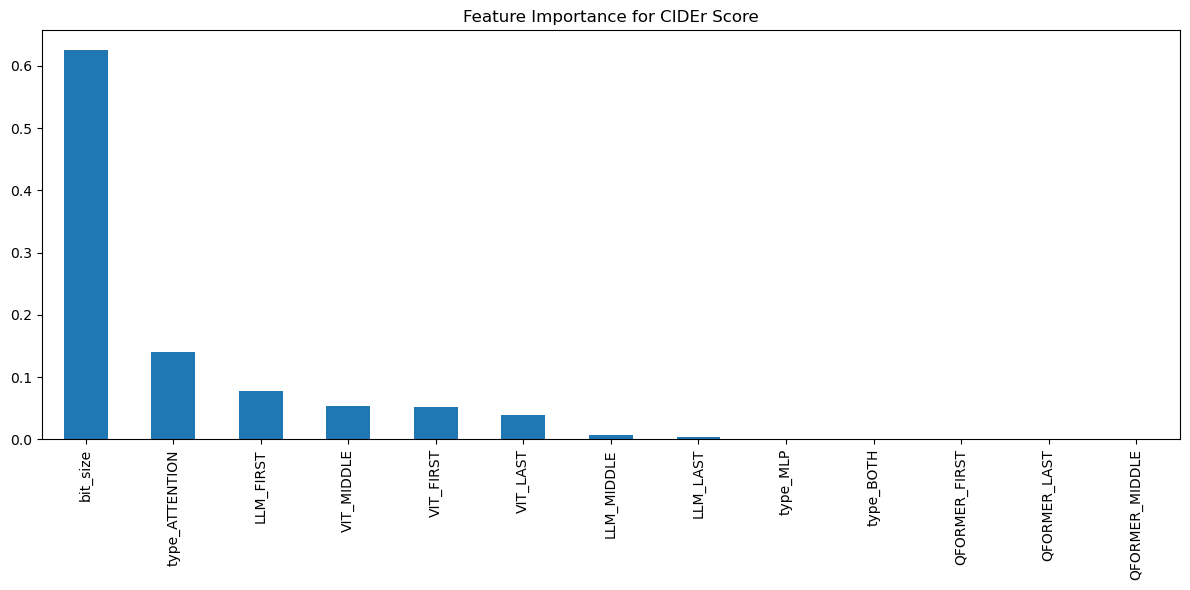

In [43]:
# Feature importance using Random Forest
X = df_encoded.drop(['METEOR', 'CIDEr'], axis=1)
y_meteor = df_encoded['METEOR']
y_cider = df_encoded['CIDEr']

rf_meteor = RandomForestRegressor(n_estimators=1, random_state=42)
rf_cider = RandomForestRegressor(n_estimators=100, random_state=42)

rf_meteor.fit(X, y_meteor)
rf_cider.fit(X, y_cider)

feature_importance_meteor = pd.Series(rf_meteor.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance_cider = pd.Series(rf_cider.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importance_meteor.plot(kind='bar')
plt.title('Feature Importance for METEOR Score')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
feature_importance_cider.plot(kind='bar')
plt.title('Feature Importance for CIDEr Score')
plt.tight_layout()
plt.show()

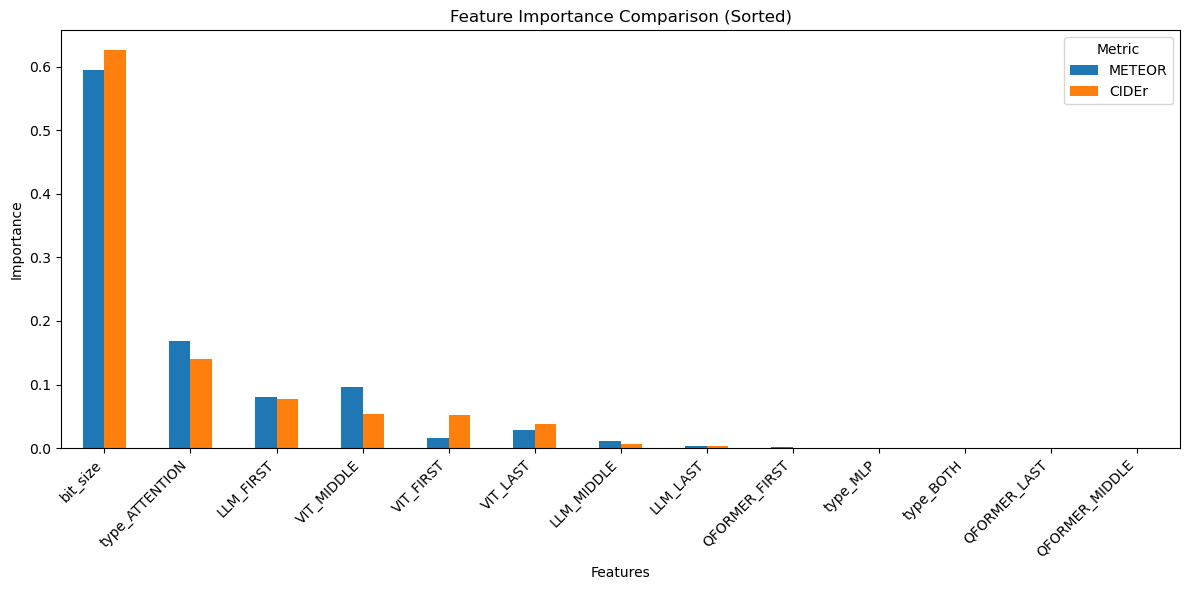

In [44]:
# Create the DataFrame
importance_df = pd.DataFrame({'METEOR': feature_importance_meteor, 'CIDEr': feature_importance_cider})

# Sort the DataFrame based on the sum of importances
importance_df['Total'] = importance_df['METEOR'] + importance_df['CIDEr']
importance_df_sorted = importance_df.sort_values('Total', ascending=False).drop('Total', axis=1)

# Plot the sorted data
ax = importance_df_sorted.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance Comparison (Sorted)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend(title='Metric')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Tree Fit Error

Performance metrics for METEOR Random Forest:
Mean cross-validation R-squared: 0.9666 (+/- 0.0591)
Mean Squared Error: 0.0001
R-squared: 0.9899


Performance metrics for CIDEr Random Forest:
Mean cross-validation R-squared: 0.9917 (+/- 0.0117)
Mean Squared Error: 0.0003
R-squared: 0.9991




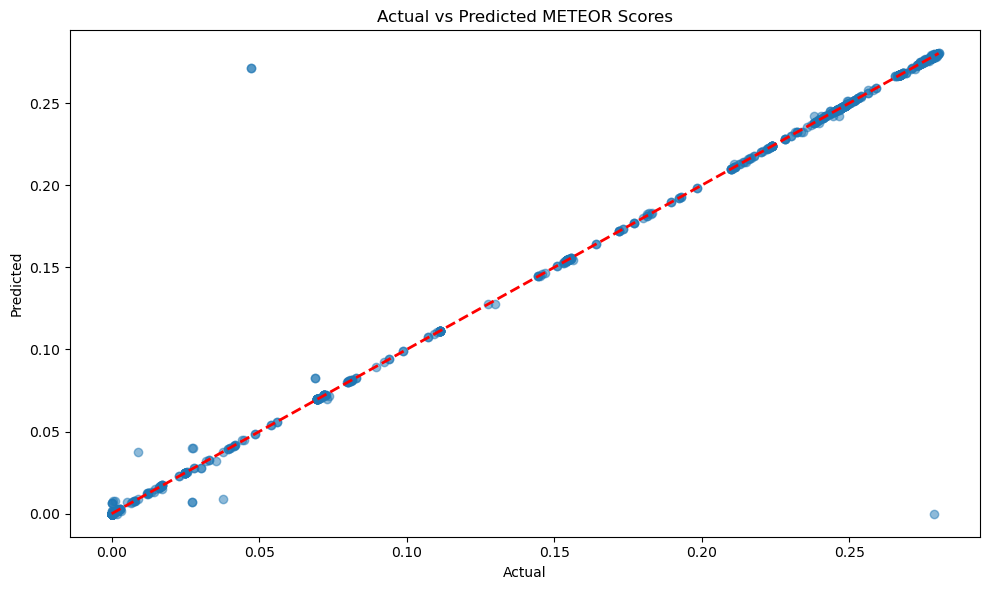

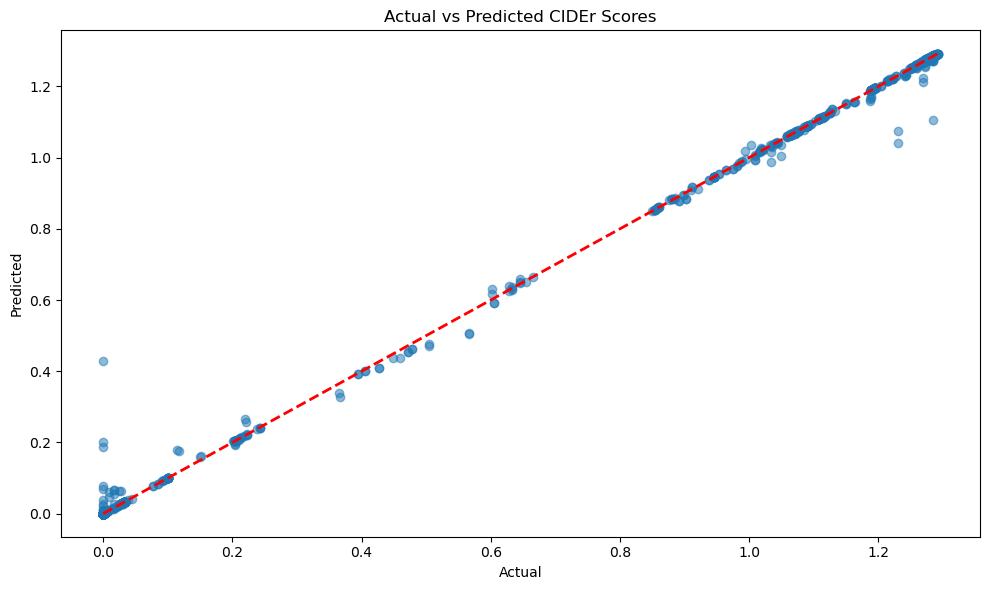

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to calculate and print model performance metrics
def print_model_performance(model, X, y, model_name):
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # Make predictions on the training set
    y_pred = model.predict(X)
    
    # Calculate MSE and R-squared
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"Performance metrics for {model_name}:")
    print(f"Mean cross-validation R-squared: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print("\n")

# Calculate and print performance metrics for METEOR model
print_model_performance(rf_meteor, X, y_meteor, "METEOR Random Forest")

# Calculate and print performance metrics for CIDEr model
print_model_performance(rf_cider, X, y_cider, "CIDEr Random Forest")

# Optional: Plot actual vs predicted values
def plot_actual_vs_predicted(model, X, y, title):
    y_pred = model.predict(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(rf_meteor, X, y_meteor, "Actual vs Predicted METEOR Scores")
plot_actual_vs_predicted(rf_cider, X, y_cider, "Actual vs Predicted CIDEr Scores")

## Drop Bit Size and Recalculate Importance

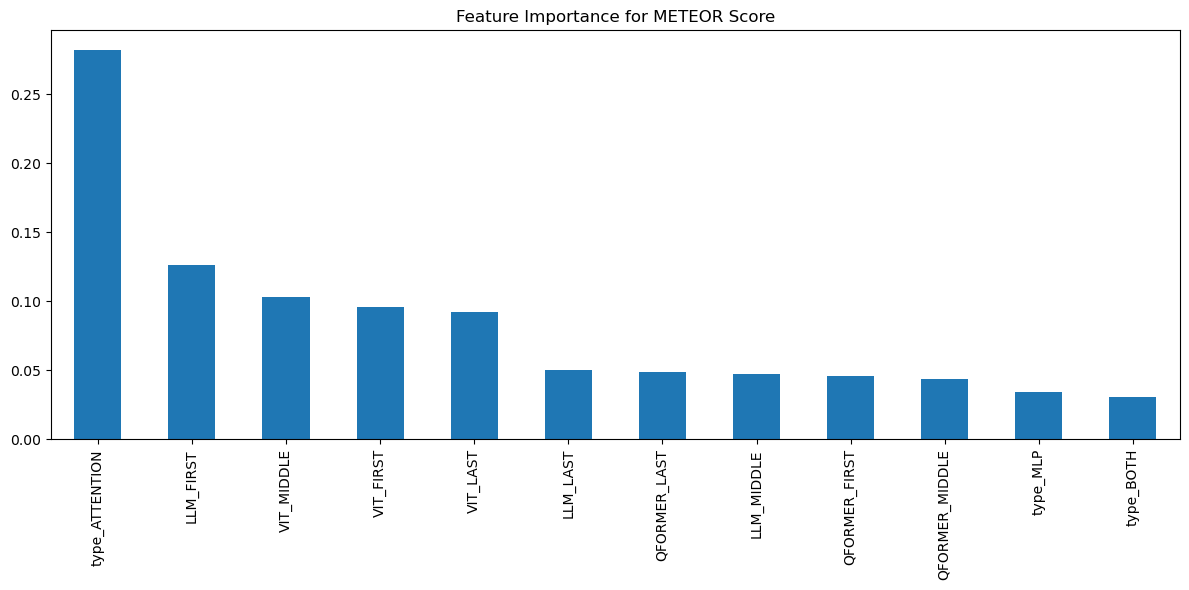

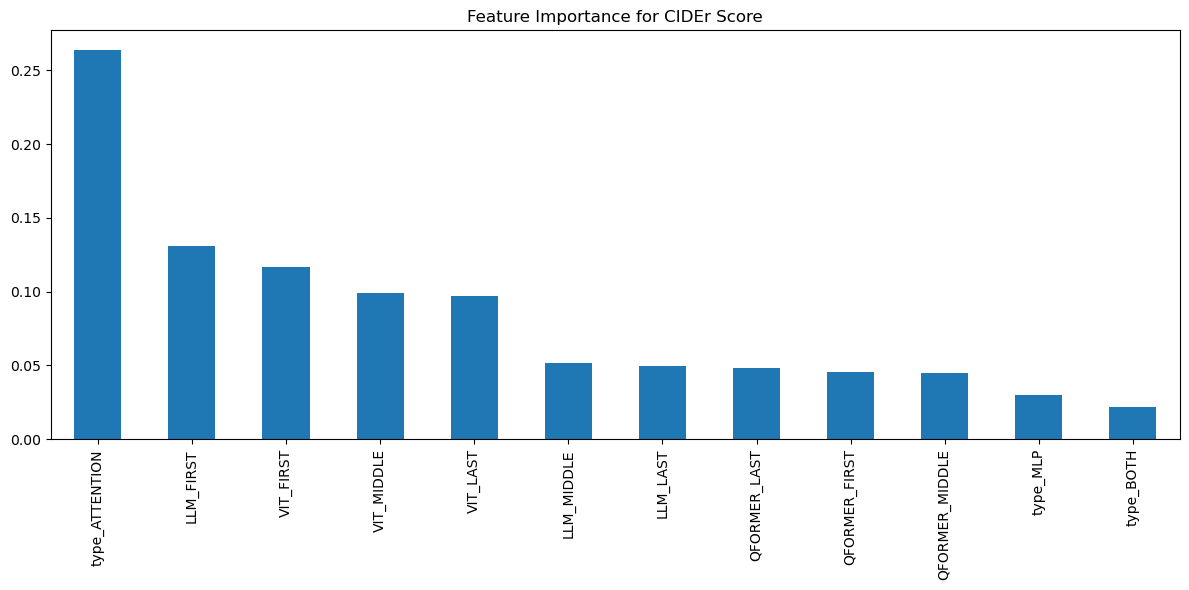

In [48]:
# Feature importance using Random Forest
df_encoded_no_bit_size = df_encoded.drop('bit_size', axis=1)
X = df_encoded_no_bit_size.drop(['METEOR', 'CIDEr'], axis=1)
y_meteor = df_encoded_no_bit_size['METEOR']
y_cider = df_encoded_no_bit_size['CIDEr']

rf_meteor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_cider = RandomForestRegressor(n_estimators=100, random_state=42)

rf_meteor.fit(X, y_meteor)
rf_cider.fit(X, y_cider)

feature_importance_meteor = pd.Series(rf_meteor.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_importance_cider = pd.Series(rf_cider.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feature_importance_meteor.plot(kind='bar')
plt.title('Feature Importance for METEOR Score')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
feature_importance_cider.plot(kind='bar')
plt.title('Feature Importance for CIDEr Score')
plt.tight_layout()
plt.show()

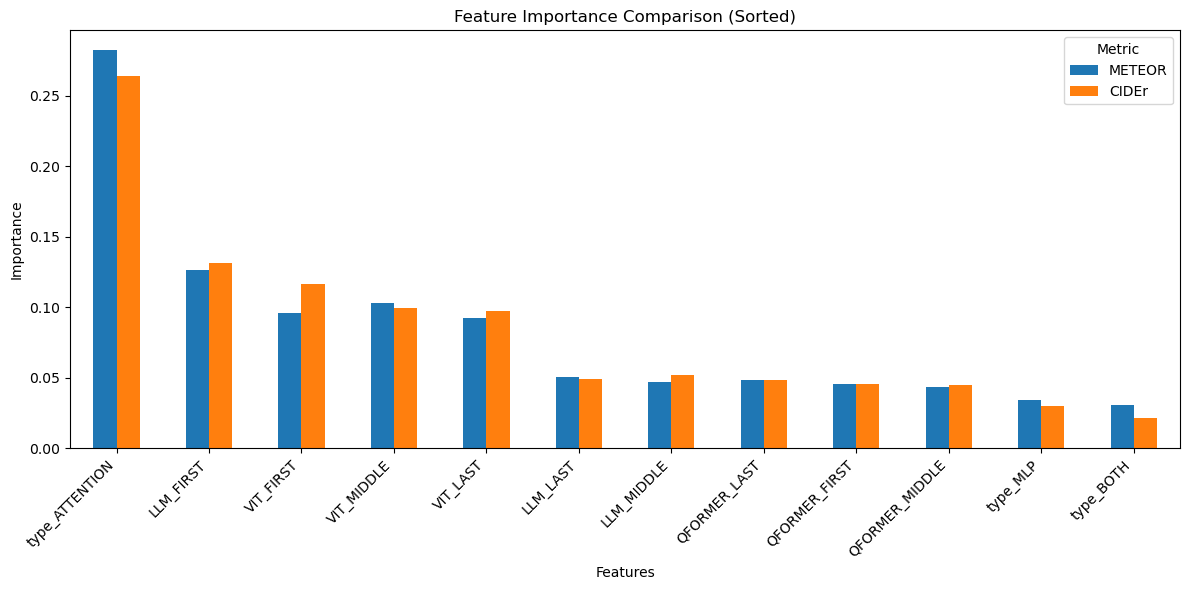

In [49]:
# Create the DataFrame
importance_df = pd.DataFrame({'METEOR': feature_importance_meteor, 'CIDEr': feature_importance_cider})

# Sort the DataFrame based on the sum of importances
importance_df['Total'] = importance_df['METEOR'] + importance_df['CIDEr']
importance_df_sorted = importance_df.sort_values('Total', ascending=False).drop('Total', axis=1)

# Plot the sorted data
ax = importance_df_sorted.plot(kind='bar', figsize=(12, 6))
plt.title('Feature Importance Comparison (Sorted)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend(title='Metric')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Performance metrics for METEOR Random Forest:
Mean cross-validation R-squared: -0.1483 (+/- 0.1811)
Mean Squared Error: 0.0095
R-squared: 0.2058


Performance metrics for CIDEr Random Forest:
Mean cross-validation R-squared: -0.1592 (+/- 0.1629)
Mean Squared Error: 0.2388
R-squared: 0.2028




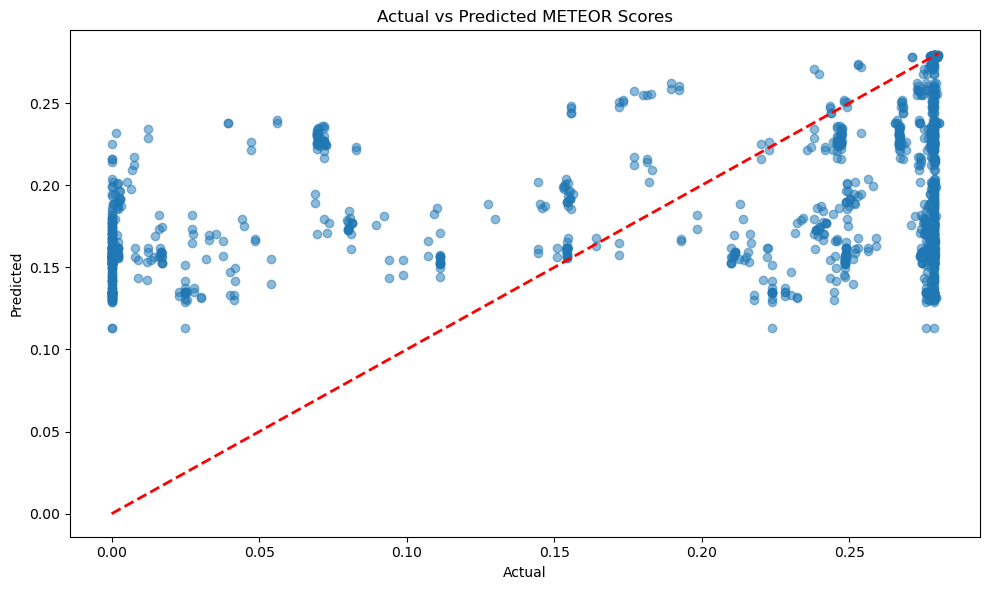

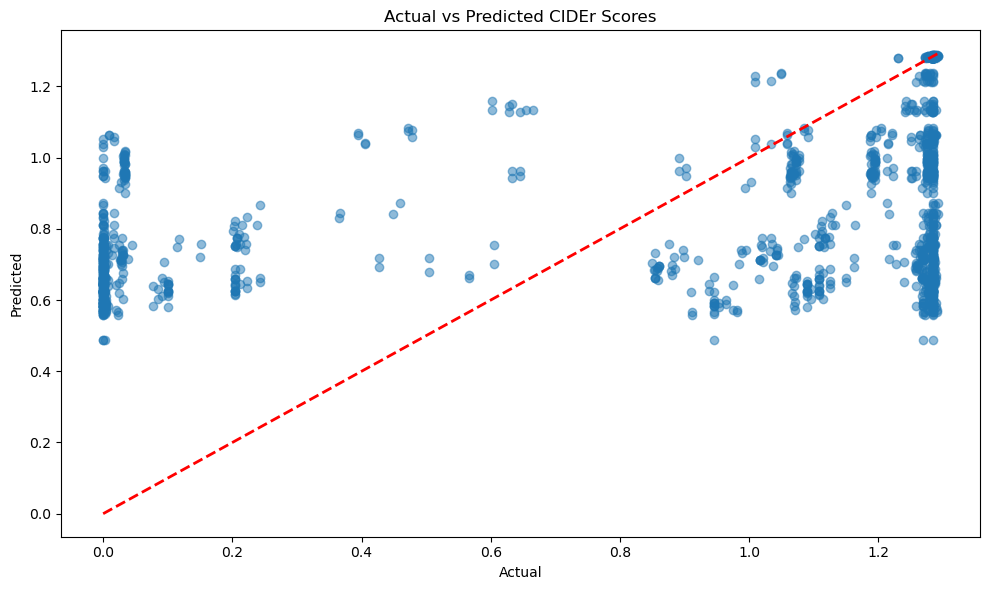

In [50]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Function to calculate and print model performance metrics
def print_model_performance(model, X, y, model_name):
    # Perform 5-fold cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    # Make predictions on the training set
    y_pred = model.predict(X)
    
    # Calculate MSE and R-squared
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    print(f"Performance metrics for {model_name}:")
    print(f"Mean cross-validation R-squared: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"R-squared: {r2:.4f}")
    print("\n")

# Calculate and print performance metrics for METEOR model
print_model_performance(rf_meteor, X, y_meteor, "METEOR Random Forest")

# Calculate and print performance metrics for CIDEr model
print_model_performance(rf_cider, X, y_cider, "CIDEr Random Forest")

# Optional: Plot actual vs predicted values
def plot_actual_vs_predicted(model, X, y, title):
    y_pred = model.predict(X)
    plt.figure(figsize=(10, 6))
    plt.scatter(y, y_pred, alpha=0.5)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_actual_vs_predicted(rf_meteor, X, y_meteor, "Actual vs Predicted METEOR Scores")
plot_actual_vs_predicted(rf_cider, X, y_cider, "Actual vs Predicted CIDEr Scores")

## Tree Visual

In [30]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# For METEOR
plt.figure(figsize=(40,20), dpi=1000)  # Increased figure size and DPI for high resolution
plot_tree(rf_meteor.estimators_[0], feature_names=X.columns, filled=True, rounded=True)
plt.title('Example Decision Tree for METEOR Score')
plt.savefig('meteor_decision_tree.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.close()

# For CIDEr
plt.figure(figsize=(40,20), dpi=1000)  # Increased figure size and DPI for high resolution
plot_tree(rf_cider.estimators_[0], feature_names=X.columns, filled=True, rounded=True)
plt.title('Example Decision Tree for CIDEr Score')
plt.savefig('cider_decision_tree.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.close()